In [3]:
from itertools import permutations
import matplotlib.axes as axes
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from typing import Optional

# import all necessary qiskit packages
from qiskit.algorithms import MinimumEigensolver, NumPyMinimumEigensolver, VQE
from qiskit.algorithms.minimum_eigensolvers import QAOA, SamplingVQE
from qiskit.algorithms.optimizers import L_BFGS_B, SLSQP, SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.tools.visualization import plot_histogram
from qiskit.utils import algorithm_globals, QuantumInstance

from qiskit_aer import Aer

from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_optimization.problems import QuadraticProgram

In [4]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=700, alpha=0.8, ax=default_axes, pos=pos, node_shape="o")
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

In [5]:
def TSPCost(energy, result_bitstring, adj_matrix):
    print("-------------------")
    print("Energy:", energy)
    print("Tsp objective:", energy + offset)
    print("Feasibility:", qubo.is_feasible(result_bitstring))
    
    solution_vector = tsp.interpret(result_bitstring)
    print("Solution Vector:", solution_vector)
    print("Solution Objective:", tsp.tsp_value(solution_vector, adj_matrix))
    print("-------------------")
    
    # Draw Graph
    draw_tsp_solution(tsp.graph, solution_vector, colors, pos)
    

In [6]:
def PlotGraph(ideal, mean):
    plt.figure(figsize=(8, 6))
    # Plot label
    for value in range(len(mean)):
        plt.plot(mean[value], label="Proposal {}".format(value+1) )
        
    # Ideal plot
    plt.axhline(y=ideal, color="tab:red", ls="--", label="Target")
    plt.legend(loc="best")
    plt.xlabel("Optimizer iteration")
    plt.ylabel("Energy")
    
    # Plot graph title
    plt.title("TSP Entangler Line {} Constraint".format(len(mean)))
    plt.show()

distance
 [[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]]


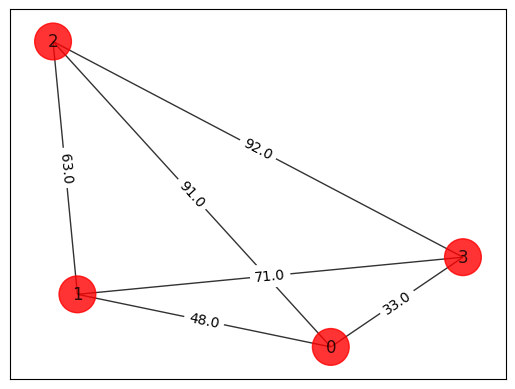

In [7]:
n = 4
num_qubits = 16

tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_matrix(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

# Brute force approach
The brute force approach involves trying every combination through classical computation to find the optimal solution. As you can infer, this procedure becomes more computationally-intensive as the number of nodes increases, or as the number of locations the traveling salesman must visit, increases.

order = (0, 1, 2, 3) Distance = 236.0
Best order from brute force = (0, 1, 2, 3) with total distance = 236.0


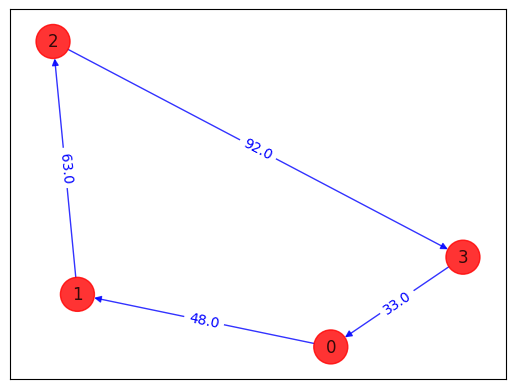

In [8]:
from itertools import permutations


def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


draw_tsp_solution(tsp.graph, best_order, colors, pos)

# Examine the quantum approach
## 1. Call the TSP Application Class and create a Quadratic Program instance
To solve this optimization problem, we first need to convert the TSP problem into a quadratic program, a program which lays out the optimization problem as a quadratic objective function and relevant constraint functions. The TSP defines variables as binary variables, so you will see those defined in the quadratic program as well.

In [9]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_3 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_3
  + 33*x_0_0*x_3_1 + 33*x_0_0*x_3_3 + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2
  + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2 + 33*x_0_1*x_3_0 + 33*x_0_1*x_3_2
  + 48*x_0_2*x_1_1 + 48*x_0_2*x_1_3 + 91*x_0_2*x_2_1 + 91*x_0_2*x_2_3
  + 33*x_0_2*x_3_1 + 33*x_0_2*x_3_3 + 48*x_0_3*x_1_0 + 48*x_0_3*x_1_2
  + 91*x_0_3*x_2_0 + 91*x_0_3*x_2_2 + 33*x_0_3*x_3_0 + 33*x_0_3*x_3_2
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_3 + 71*x_1_0*x_3_1 + 71*x_1_0*x_3_3
  + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2 + 71*x_1_1*x_3_0 + 71*x_1_1*x_3_2
  + 63*x_1_2*x_2_1 + 63*x_1_2*x_2_3 + 71*x_1_2*x_3_1 + 71*x_1_2*x_3_3
  + 63*x_1_3*x_2_0 + 63*x_1_3*x_2_2 + 71*x_1_3*x_3_0 + 71*x_1_3*x_3_2
  + 92*x_2_0*x_3_1 + 92*x_2_0*x_3_3 + 92*x_2_1*x_3_0 + 92*x_2_1*x_3_2
  + 92*x_2_2*x_3_1 + 92*x_2_2*x_3_3 + 92*x_2_3*x_3_0 + 92*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2

## 2. Convert the quadratic program to QUBO and Ising Hamiltonian
To solve this problem, we need to convert our quadratic program into a form that a quantum computer can work with. In this case we will generate an Ising Hamiltonian, which is simply a representation (i.e. model) of the energy of this particular system (i.e. problem). We can use eigensolvers to find the minimum energy of the Ising hamiltonian, which corresponds to the shortest path and the solution of our problem.

In [10]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()   #instatiate qp to qubo class
qubo = qp2qubo.convert(qp)   # convert quadratic program to qubo
qubitOp, offset = qubo.to_ising()     #convert qubo to ising


print("Offset:", offset)
print("Ising Hamiltonian:", str(qubitOp))

Offset: 51756.0
Ising Hamiltonian: -6456.0 * IIIIIIIIIIIIIIIZ
- 6456.0 * IIIIIIIIIIIIIIZI
- 6456.0 * IIIIIIIIIIIIIZII
- 6456.0 * IIIIIIIIIIIIZIII
- 6461.0 * IIIIIIIIIIIZIIII
- 6461.0 * IIIIIIIIIIZIIIII
- 6461.0 * IIIIIIIIIZIIIIII
- 6461.0 * IIIIIIIIZIIIIIII
- 6493.0 * IIIIIIIZIIIIIIII
- 6493.0 * IIIIIIZIIIIIIIII
- 6493.0 * IIIIIZIIIIIIIIII
- 6493.0 * IIIIZIIIIIIIIIII
- 6468.0 * IIIZIIIIIIIIIIII
- 6468.0 * IIZIIIIIIIIIIIII
- 6468.0 * IZIIIIIIIIIIIIII
- 6468.0 * ZIIIIIIIIIIIIIII
+ 1592.5 * IIIIIIIIIIIIIIZZ
+ 1592.5 * IIIIIIIIIIIIIZIZ
+ 1592.5 * IIIIIIIIIIIIIZZI
+ 1592.5 * IIIIIIIIIIIIZIIZ
+ 1592.5 * IIIIIIIIIIIIZIZI
+ 1592.5 * IIIIIIIIIIIIZZII
+ 1592.5 * IIIIIIIIIIIZIIIZ
+ 12.0 * IIIIIIIIIIIZIIZI
+ 12.0 * IIIIIIIIIIIZZIII
+ 12.0 * IIIIIIIIIIZIIIIZ
+ 1592.5 * IIIIIIIIIIZIIIZI
+ 12.0 * IIIIIIIIIIZIIZII
+ 1592.5 * IIIIIIIIIIZZIIII
+ 12.0 * IIIIIIIIIZIIIIZI
+ 1592.5 * IIIIIIIIIZIIIZII
+ 12.0 * IIIIIIIIIZIIZIII
+ 1592.5 * IIIIIIIIIZIZIIII
+ 1592.5 * IIIIIIIIIZZIIIII
+ 12.0 * IIIIIIIIZIIIIIIZ


## Using NumPyMinimumEigensolver to obtain a reference solution

/tmp/ipykernel_478/1790575832.py:1: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver.NumPyMinimumEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver``. See https://qisk.it/algo_migration for a migration guide.
  ee = NumPyMinimumEigensolver()


-------------------
Energy: -51520.0
Tsp objective: 236.0
Feasibility: True
Solution Vector: [1, 2, 3, 0]
Solution Objective: 236.0
-------------------


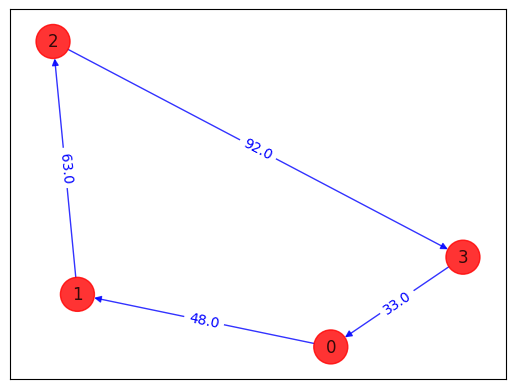

In [11]:
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

energy_numpy = result.eigenvalue.real
# Call helper function to compute cost of the obtained result and display result
TSPCost(energy = result.eigenvalue.real, result_bitstring = tsp.sample_most_likely(result.eigenstate), adj_matrix = adj_matrix)

## PQCs satisfying only the constraints on the first line

Learning problem 3 Node graph: 


/tmp/ipykernel_478/3800649323.py:23: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver.NumPyMinimumEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver``. See https://qisk.it/algo_migration for a migration guide.
  ee = NumPyMinimumEigensolver()


Ideal energy: -4751.0


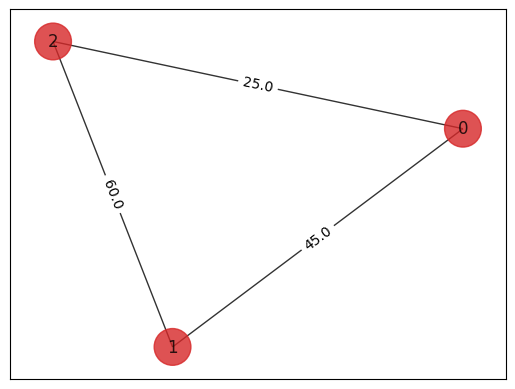

In [12]:
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=250)

adj_matrix = nx.to_numpy_matrix(tsp.graph)

# Plot graph
colors = ["tab:red" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]

print("Learning problem 3 Node graph: ")
draw_graph(tsp.graph, colors, pos)

# Define quadratic program for 4 node graph
qp = tsp.to_quadratic_program()

# Define Ising operator for 3 Node graph
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()

# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

# Ideal result
ideal = result.eigenvalue.real
print(f"Ideal energy: {ideal}")

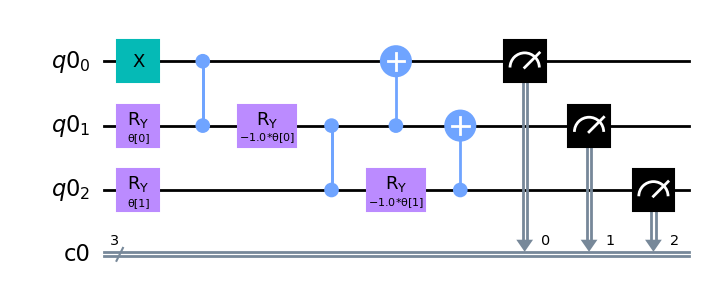

In [13]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, QuantumCircuit

# Initialize circuit
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
circuit = QuantumCircuit(qr,cr)

# Initialize Parameter with θ
theta = ParameterVector('θ', 2)

circuit.x(0)
circuit.ry(theta[0],1) 
circuit.cz(0,1)
circuit.ry((-theta[0]),1)
circuit.ry(theta[1],2) 
circuit.cz(1,2)
circuit.ry((-theta[1]),2)
circuit.cx(1,0)
circuit.cx(2,1)


circuit.measure(qr,cr)
circuit.draw("mpl")

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Initialize service and backend
#QiskitRuntimeService.save_account(channel='ibm_quantum', token='my_token', overwrite=True) #uncomment if you need to save your account again
service = QiskitRuntimeService(channel="ibm_quantum")

# Set simulator
backend = service.backends(simulator=True)[0]
print(backend)

<IBMBackend('ibmq_qasm_simulator')>


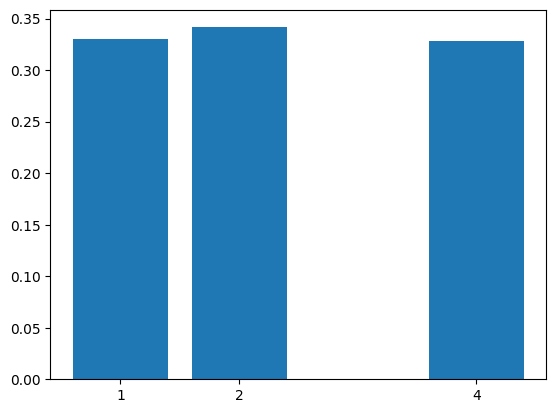

{1: 0.3298, 4: 0.3286, 2: 0.3416}


In [15]:
from math import pi
from qiskit_ibm_runtime import Session, Sampler, Options

options = Options(simulator={"seed_simulator": 42},resilience_level=0) 

parameter_values = [54.73*pi/180,45*pi/180]

# Define sampler object
with Session(service=service, backend=backend):
    sampler = Sampler(options=options) # Define sampler with options above
    result = sampler.run(circuits = [circuit], parameter_values=parameter_values, shots = 5000).result() # Run the sampler. Remember, the theta here is in degrees! :) 

# Plot result 
result_dict = result.quasi_dists[0]

values = list(result_dict.keys()) # Obtain all the values in a list
probabilities = list(result_dict.values()) # Obtain all the probabilities in a list

plt.bar(values,probabilities,tick_label=values)
plt.show()
print(result_dict)

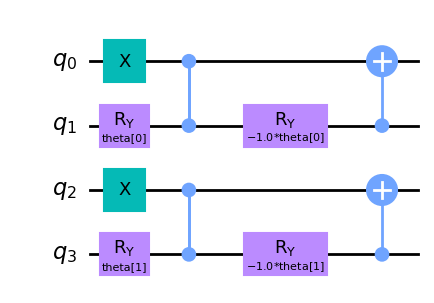

In [16]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, QuantumCircuit

# Set value of N
N = 2

# Define Circuit and ParameterVector
circuit = QuantumCircuit(N**2)
theta =  ParameterVector('theta',length=(N-1)*N)

# Block 1 ----------------
# X Gate -----------------
circuit.x(0)
# Parameter Gates --------
circuit.ry(theta[0],1)
circuit.cz(0,1)
circuit.ry(-theta[0],1)
# CX gates ---------------
circuit.cx(1,0)

# Block 2 ----------------
# X Gate -----------------
circuit.x(2)
# Parameter Gates --------
circuit.ry(theta[1],3)
circuit.cz(2,3)
circuit.ry(-theta[1],3)
# CX gates ---------------
circuit.cx(3,2)

circuit.draw("mpl")

In [17]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, QuantumCircuit

def tsp_entangler(N):
    
    # Define QuantumCircuit and ParameterVector size
    circuit = QuantumCircuit(N**2)
    theta =  ParameterVector('theta',length=(N-1)*N)
    counter = 0
    for i in range(0,N):
        circuit.x(N*i)
        # Parameter Gates
        for j in range(1,N):
            circuit.ry(theta[counter],N*i+j)
            circuit.cz(N*i+j-1,N*i+j)
            circuit.ry(-theta[counter],N*i+j)
            counter+=1
        # CX gates
        for k in range(N-1):
            circuit.cx(N*i+k+1,N*i+k)
    
    return circuit

In [18]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms.minimum_eigen_solvers import NumPyMinimumEigensolver,  MinimumEigensolver
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, VQE
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SPSA, SLSQP, L_BFGS_B
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
import numpy as np

In [19]:
PQC = tsp_entangler(3)

In [20]:
def RunVQE(estimator, model, optimizer, operator, init=None):
    
    # Store intermediate results
    history = {"eval_count": [], "parameters": [], "mean": [], "metadata": []}
    
    # Define callback function
    def store_intermediate_result(eval_count, parameters, mean, metadata):
        history["eval_count"].append(eval_count)
        history["parameters"].append(parameters)
        history["mean"].append(mean.real)
    
    # Define VQE run
    vqe = VQE(estimator=estimator, ansatz=model, optimizer=optimizer, initial_point=init, callback=store_intermediate_result)
    
    # Compute minimum_eigenvalue
    result = vqe.compute_minimum_eigenvalue(operator)
    
    return result, history["mean"]

In [21]:
# Do not change the code below and use the given seeds for successful grading
from qiskit.utils import algorithm_globals
from qiskit.primitives import Estimator
algorithm_globals.random_seed = 123

# Define optimizer
optimizer = SPSA(maxiter=50)

# Define Initial point
np.random.seed(10)
init = np.random.rand((n-1)*n) * 2 * np.pi

# Define backend
backend = service.backends(simulator=True)[0]

#### Enter your code below ####

# Call RunVQE. Do not pass in options
with Session(service = service, backend = backend):
    result, mean = RunVQE(Estimator(), PQC, optimizer, qubitOp, init=init)
        
#### Enter your code above ####

# Print result
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 100,
    'eigenvalue': -4750.85369976058,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa326fef370>,
    'optimal_parameters': {   ParameterVectorElement(theta[0]): 3.1405938762891474,
                              ParameterVectorElement(theta[5]): 3.147716694624536,
                              ParameterVectorElement(theta[4]): 4.706895428144666,
                              ParameterVectorElement(theta[3]): 4.70869194010299,
                              ParameterVectorElement(theta[2]): 4.708620211338824,
                              ParameterVectorElement(theta[1]): -1.660067101003188},
    'optimal_point': array([ 3.14059388, -1.6600671 ,  4.70862021,  4.70869194,  4.70689543,
        3.14771669]),
    'optimal_value': -4750.85369976058,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7fa326fd8220>,
    'op

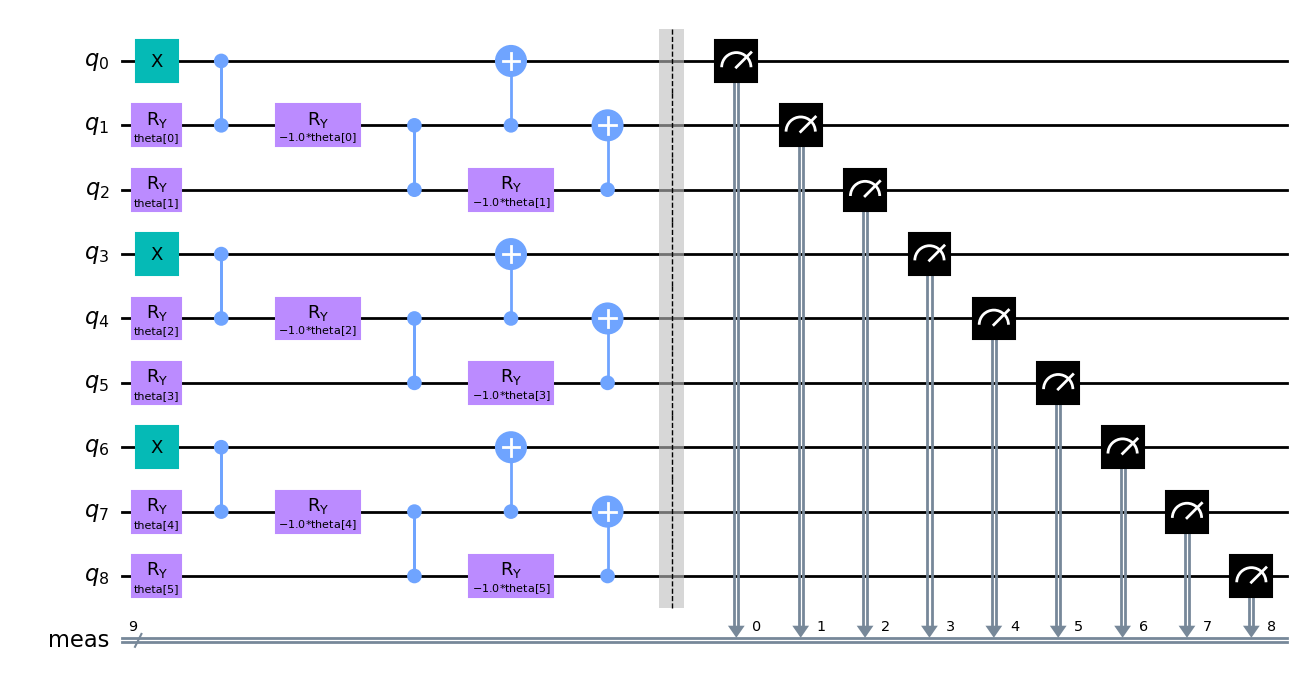

In [22]:
optimal = result.optimal_circuit.measure_all(inplace=False) # Extract optimal circuit and add measurements
optimal.draw("mpl")

In [23]:
def BestBitstring(result, optimal_circuit):
    energy = result.eigenvalue.real
    
    options = Options(simulator={"seed_simulator": 42},resilience_level=0) # Do not change and please pass it in the Sampler call for successful grading
    
    #### enter your code below ####
    with Session(service = service, backend = backend):
        sampler_result = Sampler().run(optimal_circuit, list(result.optimal_parameters.values())).result()# Enter your code here. Please do pass in options in the Sampler construct.
    result_prob_dist = sampler_result.quasi_dists[0].nearest_probability_distribution() # Obtain the nearest_probability_distribution for the sampler result from the quasi distribution obtained
   
    #### enter your code above ####
    
    max_key = format(max(result_prob_dist, key = result_prob_dist.get),"016b")

    result_bitstring = np.array(list(map(int, max_key)))
    
    return energy, sampler_result, result_prob_dist, result_bitstring

In [24]:
%%time
# Compute values
with Session(service=service, backend=backend):
    energy, sampler_result, result_prob_dist, result_bitstring = BestBitstring(result=result, optimal_circuit=optimal)
print("Optimal bitstring = ", result_bitstring[7:])

Optimal bitstring =  [0 1 0 1 0 0 0 0 1]
CPU times: user 1.27 s, sys: 12.9 ms, total: 1.28 s
Wall time: 4.8 s


-------------------
Energy: -4750.85369976058
Tsp objective: 130.14630023942027
Feasibility: True
Solution Vector: [1, 0, 2]
Solution Objective: 130.0
-------------------


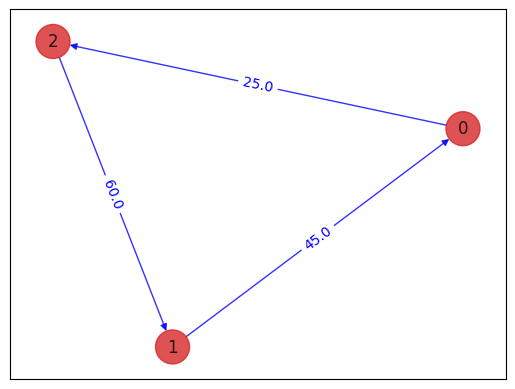

In [25]:
TSPCost(energy = energy, result_bitstring = result_bitstring[7:], adj_matrix = adj_matrix)

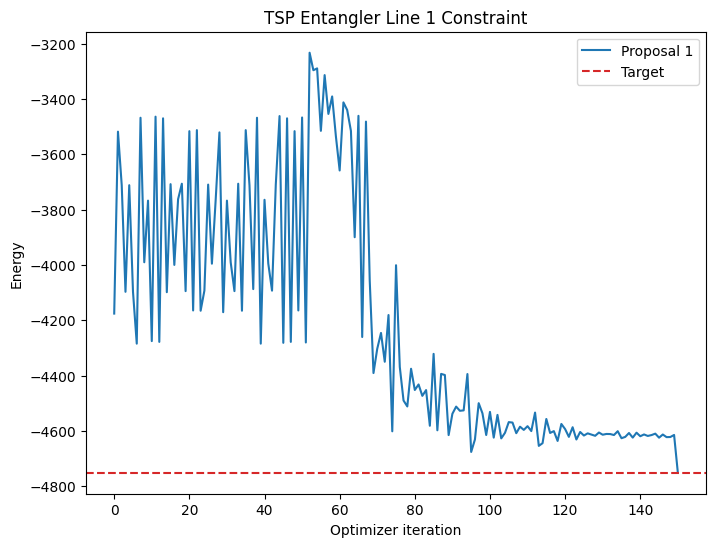

In [26]:
PlotGraph(ideal = ideal, mean = [mean])

## PQCs satisfying only the constraints on the second line Eq. (2)
Attempt in further reduction of our search subspace. Here, unlike the first PQC, we need to add more correlations among the qubits since we will be mapping more variables across the whole matrix representation. Since we have variables that appear both in the first and second line, we can no longer realize the constraints by just tensor products. Hence we will entangle the parametrized gates using gates to achieve the entanglement as mentioned.

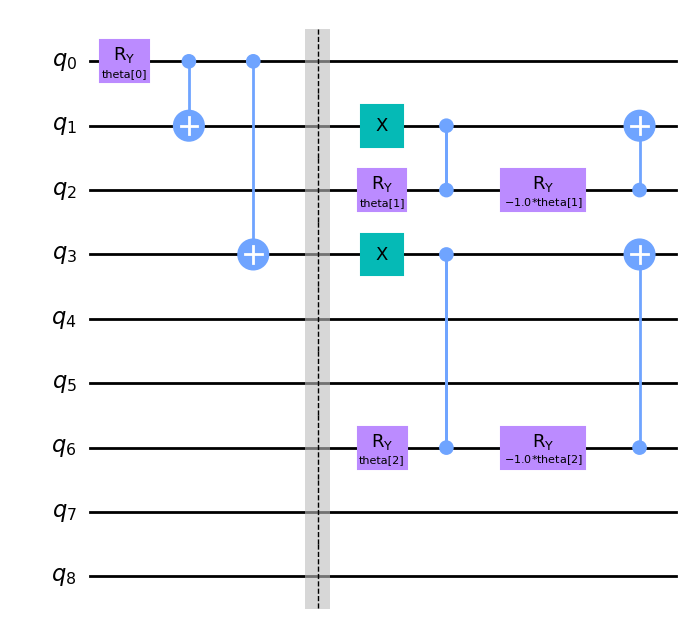

In [27]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, QuantumCircuit

l_circuit = QuantumCircuit(n**2)
theta = ParameterVector('theta',length=(n-1)*n-1)

# L-Shaped Entangler
l_circuit.ry(theta[0],0)
l_circuit.cx(0,1)
l_circuit.cx(0,3)

l_circuit.barrier()

#W_phi_p
l_circuit.x(1)
l_circuit.ry(theta[1],2)
l_circuit.cz(1,2)
l_circuit.ry(-theta[1],2)
l_circuit.cx(2,1)

#W_phi_v
l_circuit.x(3)
l_circuit.ry(theta[2],6)
l_circuit.cz(3,6)
l_circuit.ry(-theta[2],6)
l_circuit.cx(6,3)

l_circuit.draw("mpl")

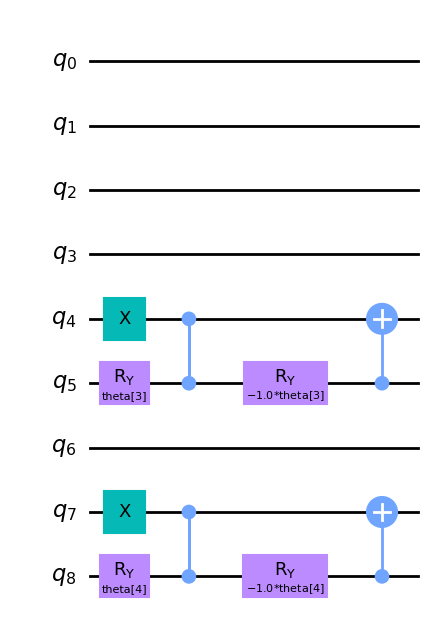

In [28]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, QuantumCircuit

r_circuit = QuantumCircuit(n**2)
theta = ParameterVector('theta',length=(n-1)*n-1)

# Two blocks remaining for N = 3
# Block 1 ---------
r_circuit.x(4)
r_circuit.ry(theta[3],5)
r_circuit.cz(4,5)
r_circuit.ry(-theta[3],5)
r_circuit.cx(5,4)


# Block 2 ---------
r_circuit.x(7)
r_circuit.ry(theta[4],8)
r_circuit.cz(7,8)
r_circuit.ry(-theta[4],8)
r_circuit.cx(8,7)

r_circuit.draw("mpl")

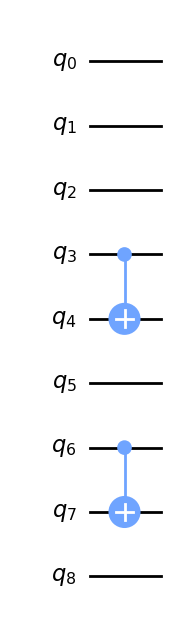

In [29]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, QuantumCircuit

bridge_circuit = QuantumCircuit(n**2)
theta = ParameterVector('theta',length=(n-1)*n-1)

bridge_circuit.cx(3,4)
bridge_circuit.cx(6,7)

bridge_circuit.draw(output="mpl")

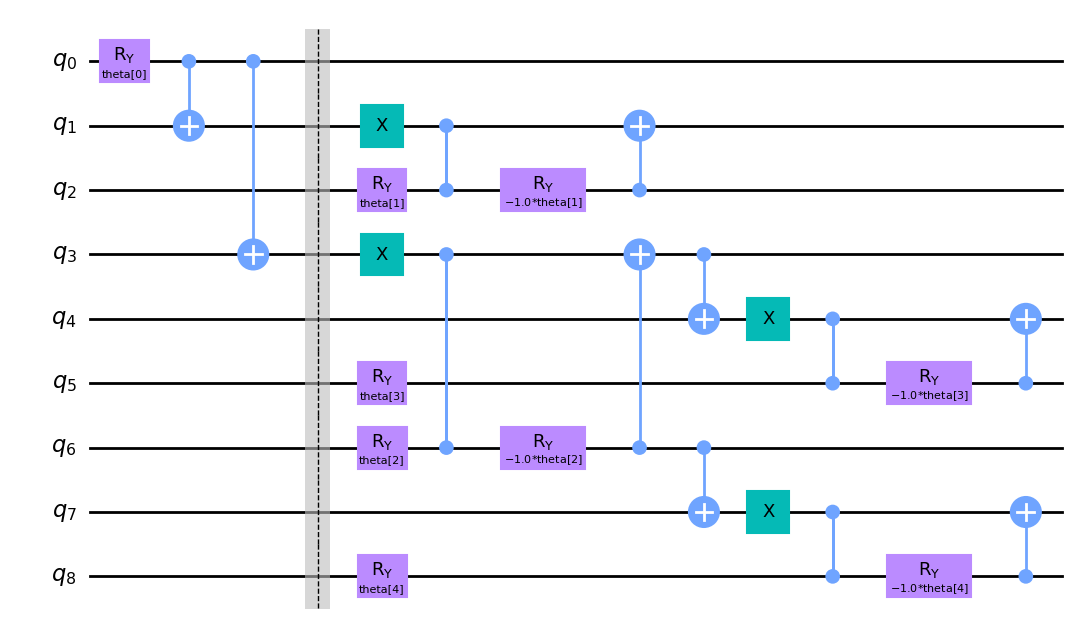

In [30]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, QuantumCircuit

model_2 = QuantumCircuit(n**2)
theta = ParameterVector('theta',length=(n-1)*n-1)

model_2 = l_circuit.compose(bridge_circuit).compose(r_circuit)
model_2.draw("mpl")

In [31]:
optimizer = SPSA()

# Define Initial point
np.random.seed(10)
init_2 = np.random.rand((n-1)*n-1) * 2 * np.pi

# Call RunVQE
with Session(service = service, backend = backend):
    result_m2, mean_m2 = RunVQE(Estimator(), model_2, optimizer, qubitOp, init=init_2)
print(result_m2, "\n")

{   'aux_operators_evaluated': None,
    'cost_function_evals': 200,
    'eigenvalue': -4750.997159699884,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa324359570>,
    'optimal_parameters': {   ParameterVectorElement(theta[4]): 3.14206670177236,
                              ParameterVectorElement(theta[2]): 4.710683482941784,
                              ParameterVectorElement(theta[0]): 4.527852355263743,
                              ParameterVectorElement(theta[1]): -0.00049640021749807,
                              ParameterVectorElement(theta[3]): 4.713051906608456},
    'optimal_point': array([ 4.52785236e+00, -4.96400217e-04,  4.71068348e+00,  4.71305191e+00,
        3.14206670e+00]),
    'optimal_value': -4750.997159699884,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7fa326305570>,
    'optimizer_time': 3.2529263496398926} 



In [32]:
optimal_m2 = result_m2.optimal_circuit.measure_all(inplace=False)

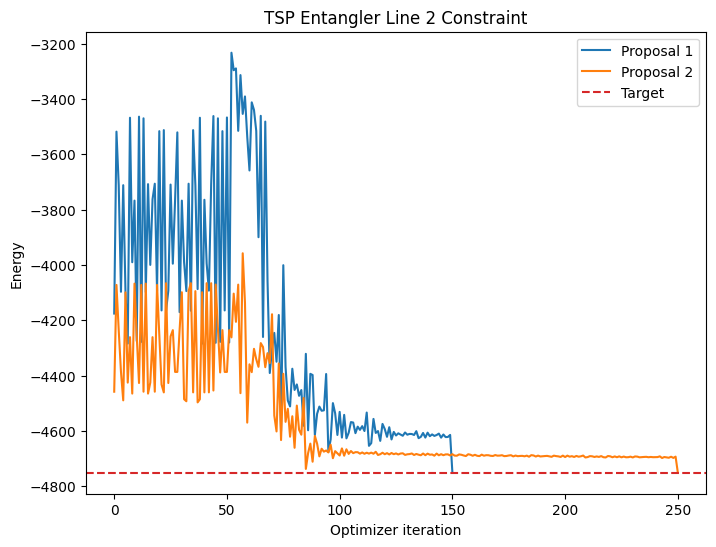

In [33]:
PlotGraph(mean = [mean,mean_m2], ideal = ideal)

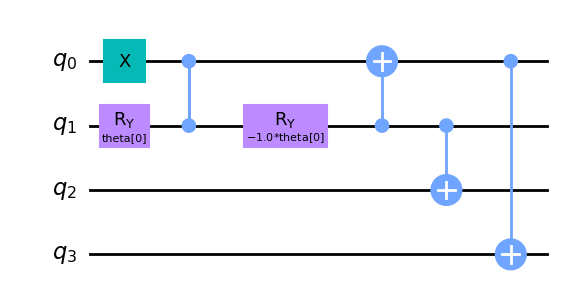

In [34]:
n = 2

perm_circuit = QuantumCircuit(n**2)
theta = ParameterVector('theta',length=(n-1)*n-1)

perm_circuit.x(0)

perm_circuit.ry(theta[0],1)
perm_circuit.cz(0,1)
perm_circuit.ry(-theta[0],1)
perm_circuit.cx(1,0)

perm_circuit.cx(1,2)
perm_circuit.cx(0,3)

perm_circuit.draw("mpl")

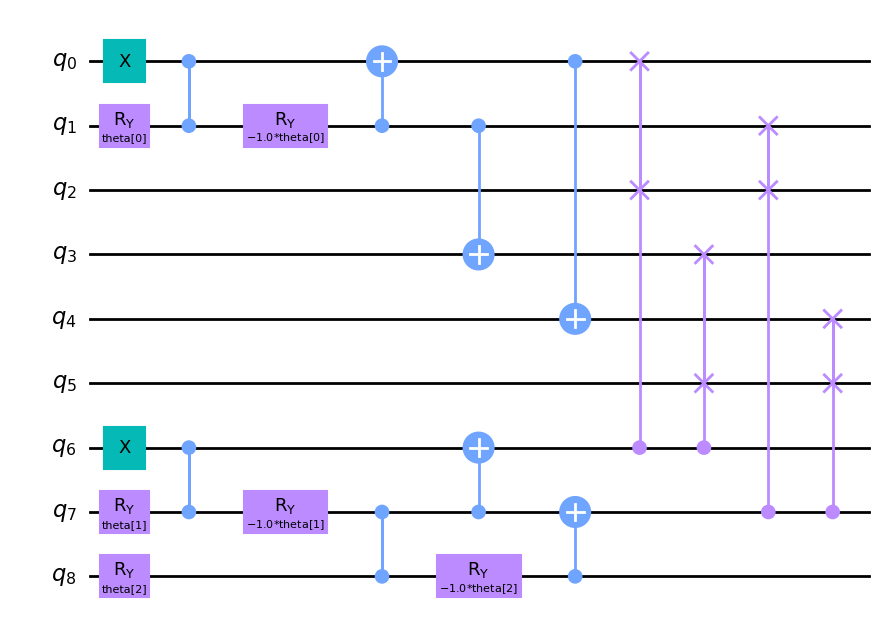

In [35]:
n = 3
model_3 = QuantumCircuit(n**2)
theta = ParameterVector('theta',length=(n-1)*n//2)

model_3.x(0)

model_3.ry(theta[0],1)
model_3.cz(0,1)
model_3.ry(-theta[0],1)
model_3.cx(1,0)

model_3.cx(1,3)
model_3.cx(0,4)

model_3.x(6)

model_3.ry(theta[1],7)
model_3.cz(6,7)
model_3.ry(-theta[1],7)

model_3.ry(theta[2],8)
model_3.cz(7,8)
model_3.ry(-theta[2],8)

model_3.cx(7,6)
model_3.cx(8,7)

model_3.cswap(6, 0, 2)
model_3.cswap(6, 3, 5)

model_3.cswap(7, 1, 2)
model_3.cswap(7, 4, 5)

model_3.draw("mpl")

In [36]:
%%time
# Define optimizer
from qiskit.primitives import Estimator
optimizer = SPSA()

# Define Initial point
np.random.seed(10)
init_3 = np.random.rand((n-1)*n//2) * 2 * np.pi

#### Enter your code below ####

# Call RunVQE. Do not pass in options
with Session(service = service, backend = backend):
    result_m3, mean_m3 = RunVQE(Estimator(), model_3, optimizer, qubitOp, init=init_3)

CPU times: user 2.85 s, sys: 73.7 ms, total: 2.92 s
Wall time: 2.98 s


In [37]:
optimal_m3 = result_m3.optimal_circuit.measure_all(inplace=False) 

In [38]:
%%time
# Compute values
with Session(service=service, backend=backend):
    energy_m3, sampler_result_m3, result_val_m3, result_m3_bitstring = BestBitstring(result=result_m3, optimal_circuit=optimal_m3)
print("Optimal bitstring = ", result_m3_bitstring[7:])

Optimal bitstring =  [0 0 1 1 0 0 0 1 0]
CPU times: user 703 ms, sys: 16 ms, total: 719 ms
Wall time: 2.69 s


-------------------
Energy: -4751.000000000002
Tsp objective: 129.99999999999818
Feasibility: True
Solution Vector: [1, 2, 0]
Solution Objective: 130.0
-------------------


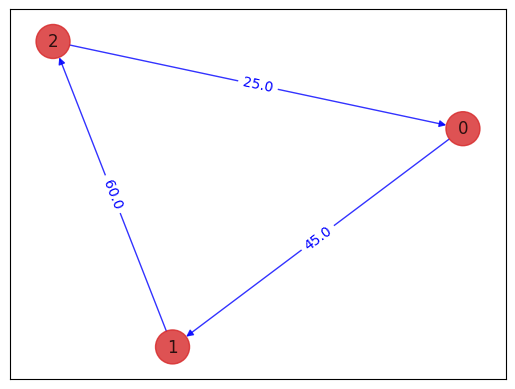

In [39]:
TSPCost(energy = energy_m3, result_bitstring = result_m3_bitstring[7:], adj_matrix = adj_matrix)

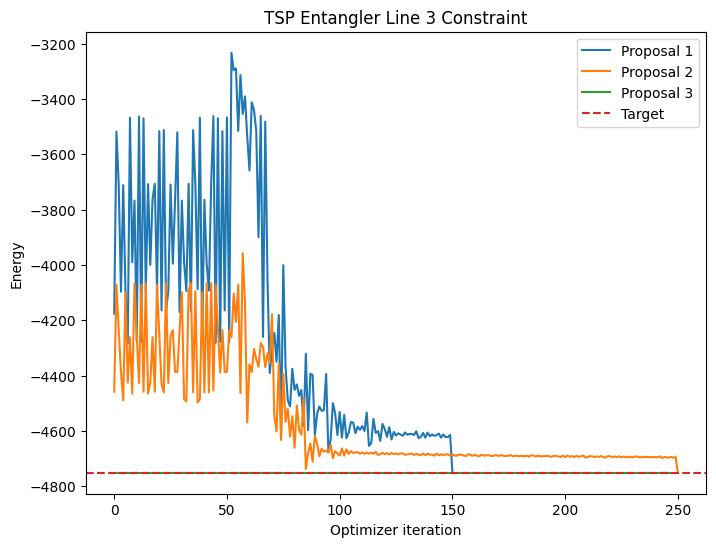

In [40]:
PlotGraph(mean = [mean,mean_m2,mean_m3], ideal = ideal)

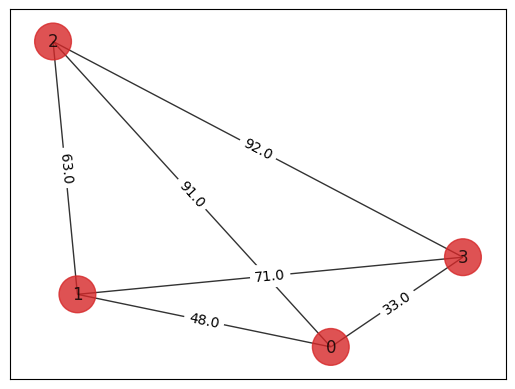

In [41]:
n = 4
num_qubits = n**2

# the target graph
tsp = Tsp.create_random_instance(n, seed=123)

colors = ["tab:red" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]

draw_graph(tsp.graph, colors, pos)

In [42]:
qp = tsp.to_quadratic_program()

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp_4, offset = qubo.to_ising()

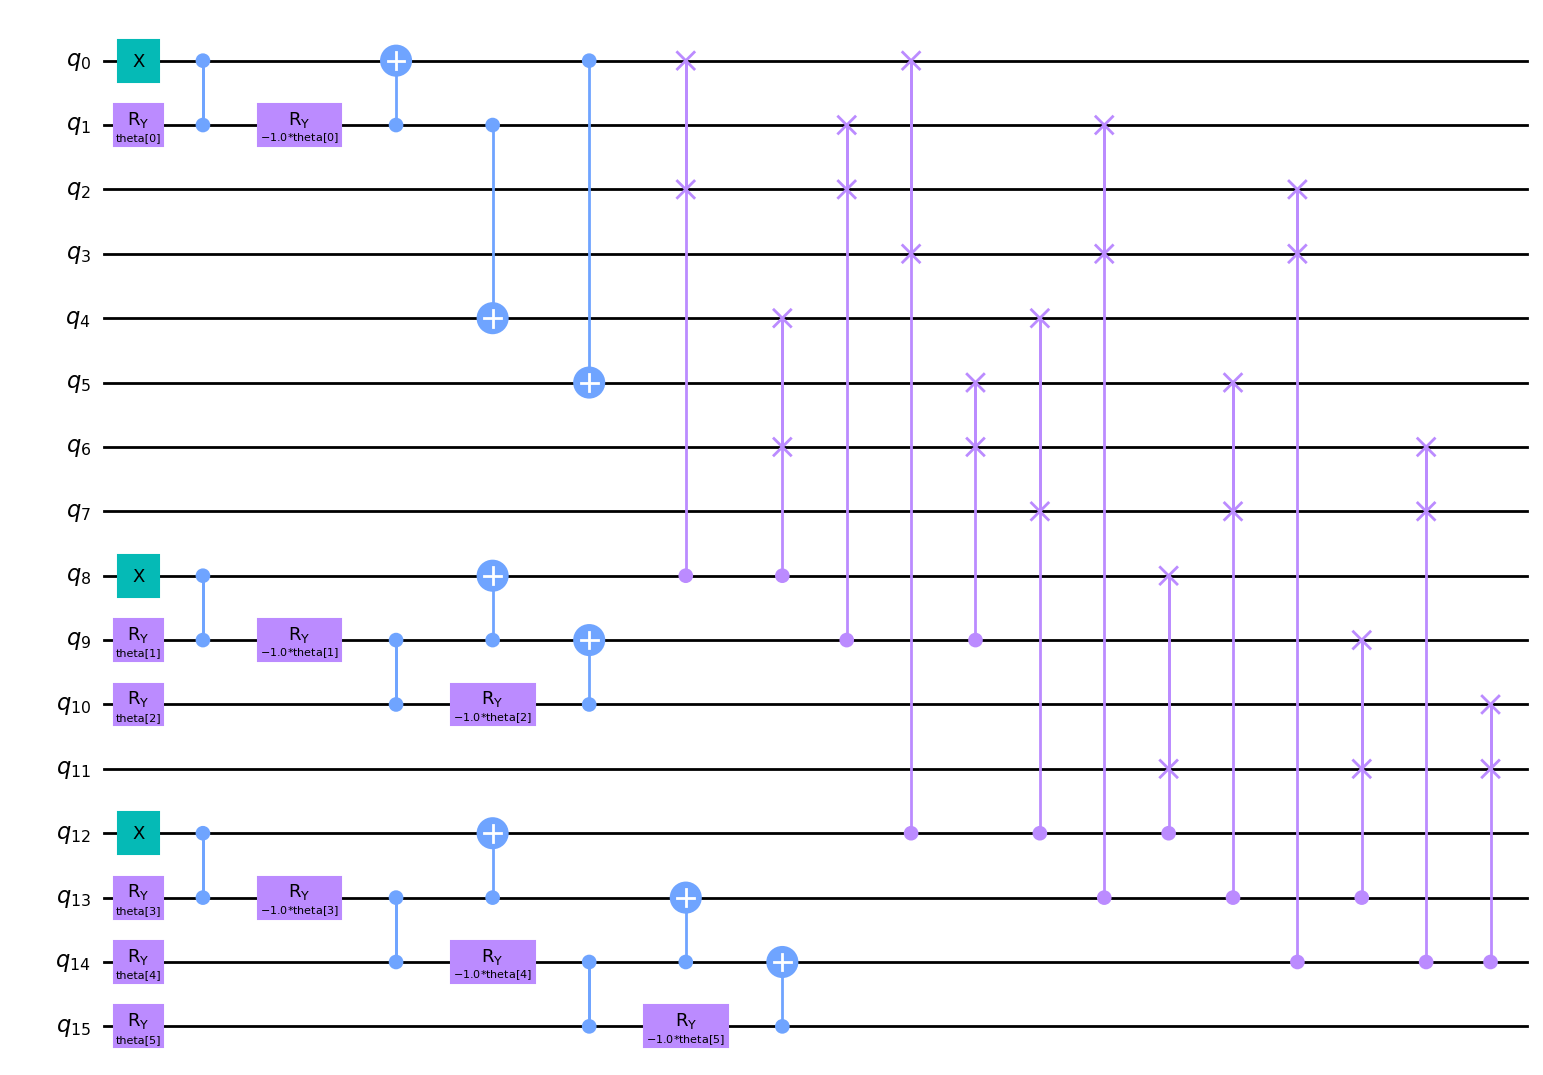

In [43]:
model = QuantumCircuit(n**2)
theta = ParameterVector('theta',length=(n-1)*n//2)
#model = tsp_entangler(n) # Type 1

model.x(0)

model.ry(theta[0],1)
model.cz(0,1)
model.ry(-theta[0],1)
model.cx(1,0)

model.cx(1,4)
model.cx(0,5)

model.x(8)

model.ry(theta[1],9)
model.cz(8,9)
model.ry(-theta[1],9)

model.ry(theta[2],10)
model.cz(9,10)
model.ry(-theta[2],10)

model.cx(9,8)
model.cx(10,9)

model.cswap(8, 0, 2)
model.cswap(8, 4, 6)
model.cswap(9, 1, 2)
model.cswap(9, 5, 6)

model.x(12)

model.ry(theta[3],13)
model.cz(12,13)
model.ry(-theta[3],13)

model.ry(theta[4],14)
model.cz(13,14)
model.ry(-theta[4],14)

model.ry(theta[5],15)
model.cz(14,15)
model.ry(-theta[5],15)

model.cx(13,12)
model.cx(14,13)
model.cx(15,14)
model.cswap(12, 0, 3)
model.cswap(12, 4, 7)
model.cswap(12, 8, 11)

model.cswap(13, 1, 3)
model.cswap(13, 5, 7)
model.cswap(13, 9, 11)

model.cswap(14, 2, 3)
model.cswap(14, 6, 7)
model.cswap(14, 10, 11)

model.draw("mpl")

In [44]:
%%time
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 1024

options = Options(simulator={"seed_simulator": 42},resilience_level=0)

# Define optimizer
optimizer = SPSA(maxiter=100)

# Define Initial point
np.random.seed(10)
init = np.random.rand((n-1)*n//2) * 2 * np.pi

# Define backend
backend = service.backends(simulator=True)[0]

# Call RunVQE
with Session(service = service, backend = backend):
    result_4, mean = RunVQE(Estimator(), model, optimizer, qubitOp_4, init=init)
    
# Print result
print(result_4)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 200,
    'eigenvalue': -51519.99981699653,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa326e3d390>,
    'optimal_parameters': {   ParameterVectorElement(theta[1]): 1.969067214793429,
                              ParameterVectorElement(theta[0]): 6.282792339574749,
                              ParameterVectorElement(theta[3]): 1.5721265678673573,
                              ParameterVectorElement(theta[2]): 1.572015226117477,
                              ParameterVectorElement(theta[5]): 1.5720577136833556,
                              ParameterVectorElement(theta[4]): 4.683137339143627},
    'optimal_point': array([6.28279234, 1.96906721, 1.57201523, 1.57212657, 4.68313734,
       1.57205771]),
    'optimal_value': -51519.99981699653,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7fa326477e20>,
    'optim

In [45]:
optimal = result_4.optimal_circuit.measure_all(inplace=False)

In [48]:
%%time
# Compute values
with Session(service=service, backend=backend):
    energy, sampler_result, result_val, bitstring = BestBitstring(result=result_4, optimal_circuit=optimal)
print("Optimal bitstring = ", bitstring)

Optimal bitstring =  [1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1]
CPU times: user 286 ms, sys: 18.4 ms, total: 304 ms
Wall time: 1.2 s


/tmp/ipykernel_478/483269632.py:1: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver.NumPyMinimumEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver``. See https://qisk.it/algo_migration for a migration guide.
  ee = NumPyMinimumEigensolver()


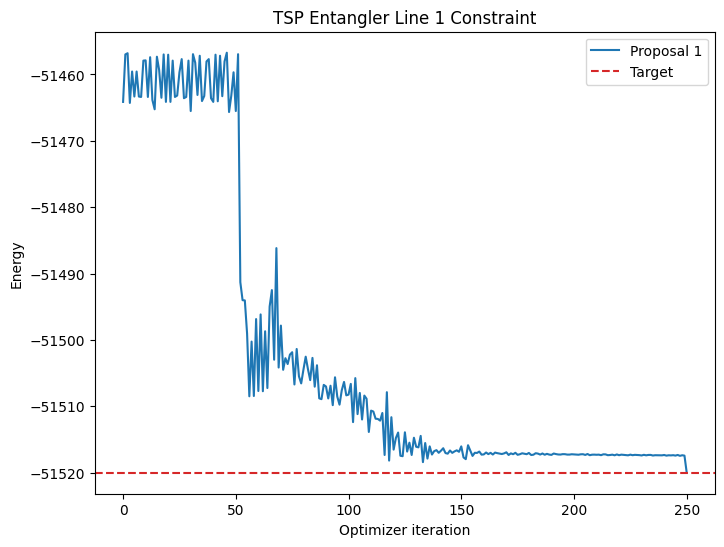

In [49]:
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp_4)
energy_numpy = result.eigenvalue.real

PlotGraph(mean = [mean], ideal = energy_numpy)

In [50]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Options, Session

# # Initialize service and backend
# #QiskitRuntimeService.save_account(channel='ibm_quantum', token='my_token', overwrite=True) #uncomment if you need to save your account again
service = QiskitRuntimeService(channel="ibm_quantum")

# # Set simulator
backend = service.backends(simulator=True)[0]
print(backend)

<IBMBackend('simulator_mps')>


In [52]:
from qiskit.providers.fake_provider import FakeGuadalupe
from qiskit_aer.noise import NoiseModel

fake_backend = FakeGuadalupe()
noise_model = NoiseModel.from_backend(fake_backend)

options = Options(
    simulator={
        "noise_model": noise_model,
        "seed_simulator": 42,
    },
    resilience_level=0  
)

Learning problem 3 Node graph: 


/tmp/ipykernel_478/598102711.py:22: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver.NumPyMinimumEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver``. See https://qisk.it/algo_migration for a migration guide.
  ee = NumPyMinimumEigensolver()


Ideal energy: -51520.0


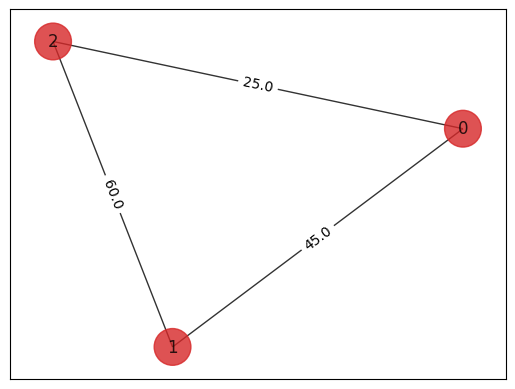

In [53]:
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=250)

adj_matrix = nx.to_numpy_matrix(tsp.graph)

colors = ["tab:red" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]

print("Learning problem 3 Node graph: ")
draw_graph(tsp.graph, colors, pos)

# Define quadratic program for 4 node graph
qp = tsp.to_quadratic_program()

# Define Ising operator for 3 Node graph
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()

# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

ideal = result.eigenvalue.real
print(f"Ideal energy: {energy_numpy}")

In [54]:
%%time
optimizer = SPSA(maxiter= 50)
init =  np.random.rand((n-1)*n) * 2 * np.pi
model_1 = tsp_entangler(3)
with Session(service = service, backend = backend):
    print("Running model 1......")
    result_n, mean_n = RunVQE(Estimator(options=options), model_1, optimizer, qubitOp, init=init)
    print("Model 1 simulation complete")

Running model 1......


AlgorithmError: 'The primitive job to evaluate the energy failed!'

In [55]:
%%time  
with Session(service = service, backend = backend):    
    print("Running model 2......")
    result_m2_n, mean_m2_n = RunVQE(Estimator(options=options), model_2, optimizer, qubitOp, init=init_2)
    print("Model 2 simulation complete")

Running model 2......


AlgorithmError: 'The primitive job to evaluate the energy failed!'

As expected, model 1 took an enormous amount of time to run, hence failing.

In [56]:
%%time
n=3
init_3 = np.random.rand((n-1)*n//2) * 2 * np.pi
with Session(service = service, backend = backend):    
    print("Running model 3......")
    result_m3_n, mean_m3_n = RunVQE(Estimator(options=options), model_3, optimizer, qubitOp, init=init_3)
    print("Model 3 simulation complete")

Running model 3......
Model 3 simulation complete
CPU times: user 1min 17s, sys: 970 ms, total: 1min 17s
Wall time: 37min 29s


In [ ]:
# Plot convergence
PlotGraph(mean = [mean_n,mean_m2_n,mean_m3_n], ideal = ideal)

In [ ]:
# Set options for Digital ZNE routine
options = Options(
    simulator={
        "noise_model": noise_model,
        "seed_simulator": 42,
    }, 
)

# Settings to set noise_factors, noise_amplifier and extrapolator
options.resilience.noise_factors = (1, 2, 3, 4) # Set noise_factors 
options.resilience.noise_amplifer = 'CxAmplifer' # Set noise_amplifiers
options.resilience.extrapolator = 'QuadraticExtrapolator' # Set noise_extrapolators

In [ ]:
%%time
optimizer = SPSA({"maxiter": 10})
with Session(service = service, backend = backend):
    print("Running model 1......")
    result_zn, mean_zn = RunVQE(Estimator(options=options), model_1, optimizer, qubitOp, init=init)
    print("Model 1 simulation complete")
    
    print("Running model 2......")
    result_m2_zn, mean_m2_zn = RunVQE(Estimator(options=options), model_2, optimizer, qubitOp, init=init_2)
    print("Model 2 simulation complete")
    
    print("Running model 3......")
    result_m3_zn, mean_m3_zn = RunVQE(Estimator(options=options), model_3, optimizer, qubitOp, init=init_3)
    print("Model 3 simulation complete")

In [ ]:
# Plot convergence
PlotGraph(mean = [mean_zn,mean_m2_zn,mean_m3_zn], ideal = energy_numpy)